# Auto-picking of Zond Aero500 GPR data from Chena Lake

In [3]:
import sys
import zond_ugcs
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import pandas as pd
import verde as vd
import pyproj
import cartopy.crs as ccrs
from rasterio.transform import Affine
import rasterio as rio

## Read in data

In [22]:
#file = "../data/08_Mar_2023/2023-03-09-00-42-10-gpr.sgy"
#file = "../data/08_Mar_2023/2023-03-09-00-09-14-gpr.sgy"
file = "../data/08_Mar_2023/2023-03-08-23-16-49-gpr.sgy"
rx = zond_ugcs.read(file, loglevel="INFO")

[2023-03-13 21:31:52] - zond_ugcs - INFO: Beginning Zond Aero 500 file read
[2023-03-13 21:31:52] - zond_ugcs - INFO: Opening data file: ./data/08_Mar_2023/2023-03-08-23-16-49-gpr.sgy
[2023-03-13 21:31:52] - zond_ugcs - INFO: Opened data file
[2023-03-13 21:31:52] - zond_ugcs - INFO: Data file size: 96279952 bytes
[2023-03-13 21:31:52] - zond_ugcs - INFO: Reading text header
[2023-03-13 21:31:52] - zond_ugcs - INFO: Reading binary header
[2023-03-13 21:31:52] - zond_ugcs - INFO: Data file contains 76168 traces
[2023-03-13 21:31:52] - zond_ugcs - INFO: Sample interval: 195 picoseconds
[2023-03-13 21:31:52] - zond_ugcs - INFO: Reading traces
[2023-03-13 21:31:57] - zond_ugcs - INFO: Data file read successfully
[2023-03-13 21:31:57] - zond_ugcs - INFO: Opening position file: ./data/08_Mar_2023/2023-03-08-23-16-49-position.csv
[2023-03-13 21:31:57] - zond_ugcs - INFO: Decimating position file to integer trace indices
[2023-03-13 21:31:57] - zond_ugcs - INFO: 89% of traces have RTK fix
[202

## Preliminary plot

/tmp/ipykernel_92956/2152214581.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(np.abs(rx["bscan"])+1), aspect="auto")


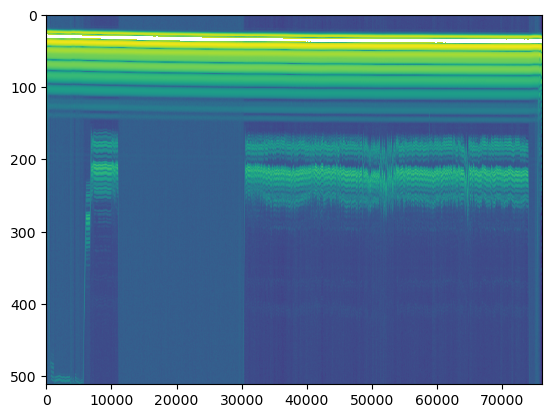

In [23]:
plt.imshow(np.log10(np.abs(rx["bscan"])+1), aspect="auto")

## Plot of trimmed data

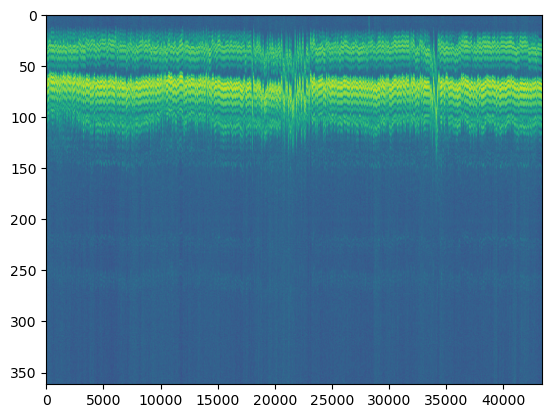

In [24]:
# 42-10
#triml = 2600
#trimr = 53575

# 09-14
#triml = 1575
#trimr = 54350

# 15-49
triml = 30575
trimr = 74000

bscan = rx["bscan"][150:,triml:trimr]
lat = rx["lat"][triml:trimr]
lon = rx["lon"][triml:trimr]
plt.imshow(np.log10(np.abs(bscan)+1), aspect="auto")

## Envelope of trimmed data

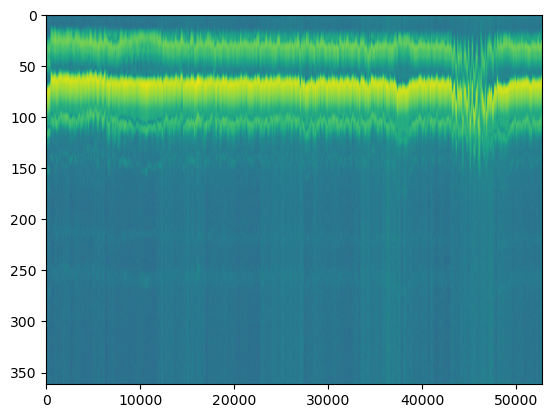

In [8]:
bscanEnv = np.abs(sig.hilbert(bscan, axis=0))
plt.imshow(np.log10(np.abs(bscanEnv)+1), aspect="auto")

## Use scipy find_peaks to extract ice surface and bottom location in radargram

Text(0, 0.5, 'Sample')

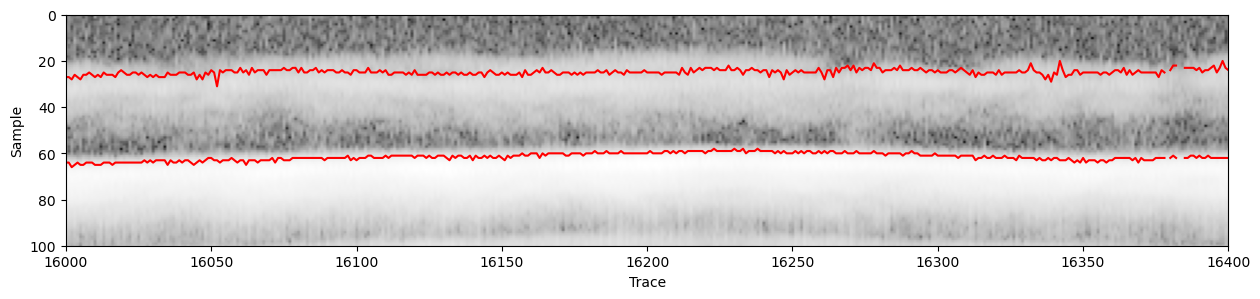

In [26]:
pickSrf = np.zeros(bscan.shape[1])*np.nan
pickBed = np.zeros(bscan.shape[1])*np.nan
for i in range(bscan.shape[1]):
    tr = bscanEnv[:,i]
    peaks, props = sig.find_peaks(tr, prominence=200)
    if(len(peaks) < 2):
        continue
    pickSrf[i] = peaks[0]-5
    pickBed[i] = peaks[1]-5

plt.figure(figsize=(15, 3))
plt.imshow(np.log10(np.abs(bscanEnv)+1), aspect="auto", cmap="Greys_r")
plt.plot(pickBed, 'r-')
plt.plot(pickSrf, 'r-')
xl = 16000
plt.xlim(xl, xl+400)
plt.ylim(100, 0)
plt.xlabel("Trace")
plt.ylabel("Sample")

## Calculate and spit out ice thickness

In [56]:
sampThick = pickBed-pickSrf
twttThick = sampThick*rx["dt"]
c = 299792458
eps = 3.15
hThick = (twttThick/2)*(c/np.sqrt(eps))

In [71]:
# Filter out some bad auto-picks - this is just empirical 
for i,t in enumerate(hThick):
    if(t < .4):
        hThick[i] = np.nan

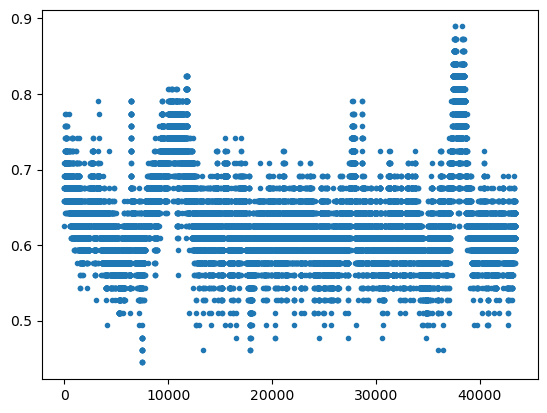

In [72]:
# Plot thicknesses
plt.plot(hThick, '.')

In [73]:
dfDict = {
    "thick": hThick,
    "lat": lat,
    "lon": lon,
}
df = pd.DataFrame(dfDict)
df.to_csv(file.replace(".sgy", ".csv"))

# Try interpolating with verde

In [75]:
# Read in all of the data from three chena lake files
df1 = pd.read_csv("../data/08_Mar_2023/2023-03-08-23-16-49-gpr.csv")
df2 = pd.read_csv("../data/08_Mar_2023/2023-03-09-00-09-14-gpr.csv")
df3 = pd.read_csv("../data/08_Mar_2023/2023-03-09-00-42-10-gpr.csv")

df = pd.concat((df1, df2, df3))

df["owtt"] = df["thick"]/(c/np.sqrt(3.15))

In [76]:
# Need to project to a meter-meters grid. Will use UTM
xform = pyproj.Transformer.from_crs(4326, 32606)
df["x"], df["y"] = xform.transform(df["lat"], df["lon"])

## Plot data

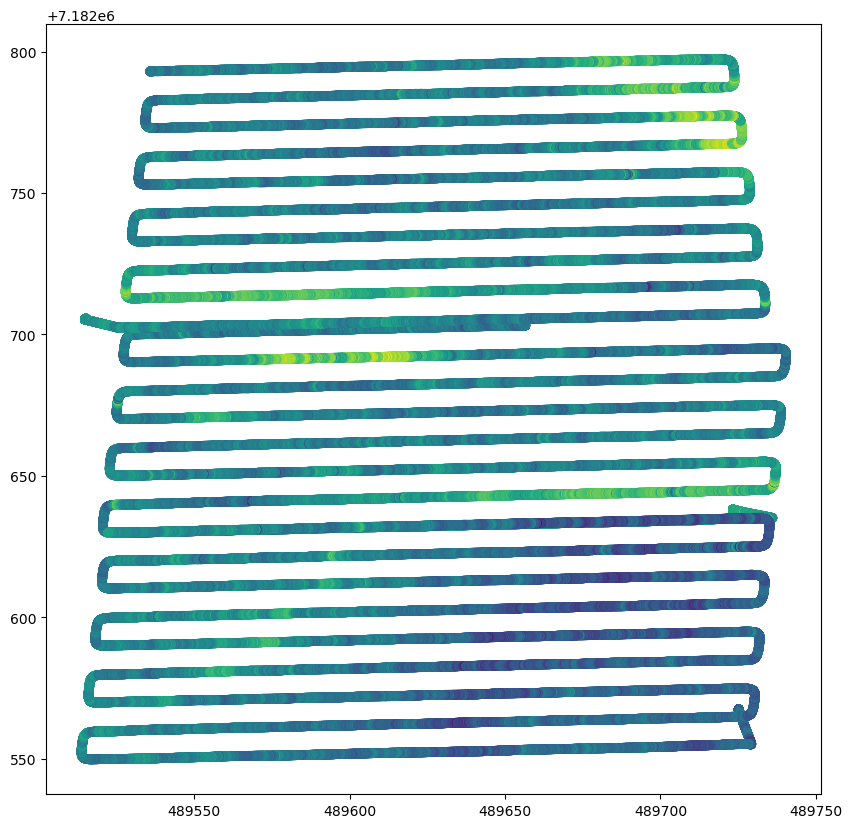

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(df["x"], df["y"], c=df["thick"])
plt.show()

## Block reduce data

Original # data points: 147175
Reduced # data points: 1119


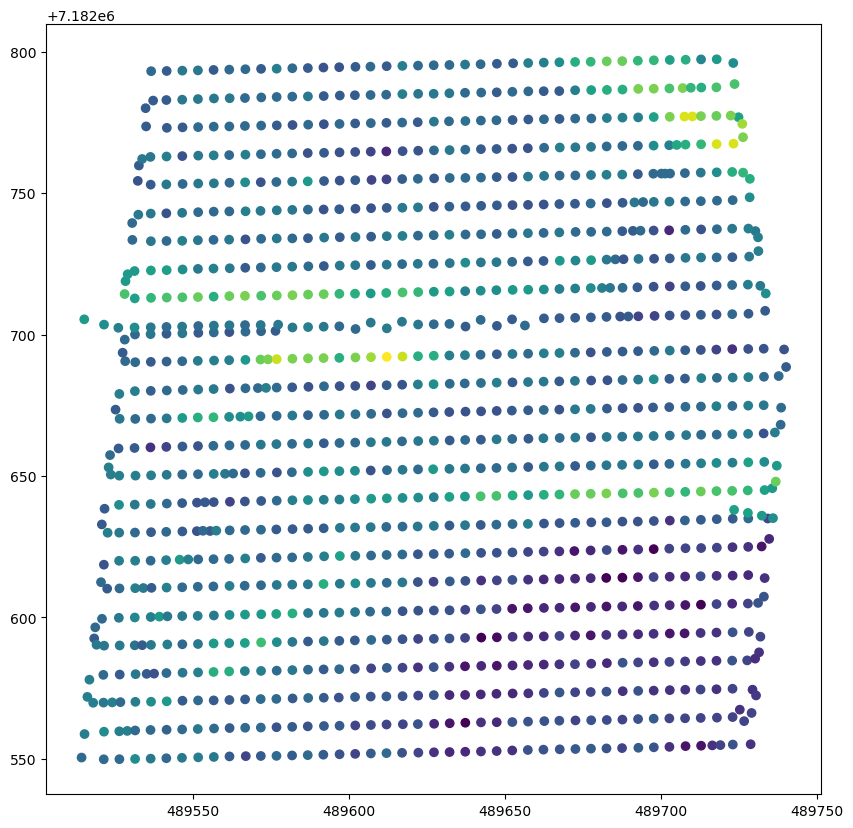

In [78]:
spacing = 5 # This gets used through the rest of the notebook - it is also the cell size for the interpolated raster

reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, center_coordinates=False)

coordinates, thick = reducer.filter(
    (df.x, df.y), np.round(df.thick,2)
)
x, y = coordinates

print("Original # data points:", len(df.thick))
print("Reduced # data points:", thick.size)

plt.figure(figsize=(10,10))
plt.scatter(x,y,c=thick)
plt.show()

## Grid data

Generated grid:
<xarray.Dataset>
Dimensions:  (x: 50, y: 46)
Coordinates:
  * y        (y) float64 4.895e+05 4.895e+05 4.895e+05 ... 4.897e+05 4.897e+05
  * x        (x) float64 7.183e+06 7.183e+06 7.183e+06 ... 7.183e+06 7.183e+06
Data variables:
    thick    (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder(method='linear')


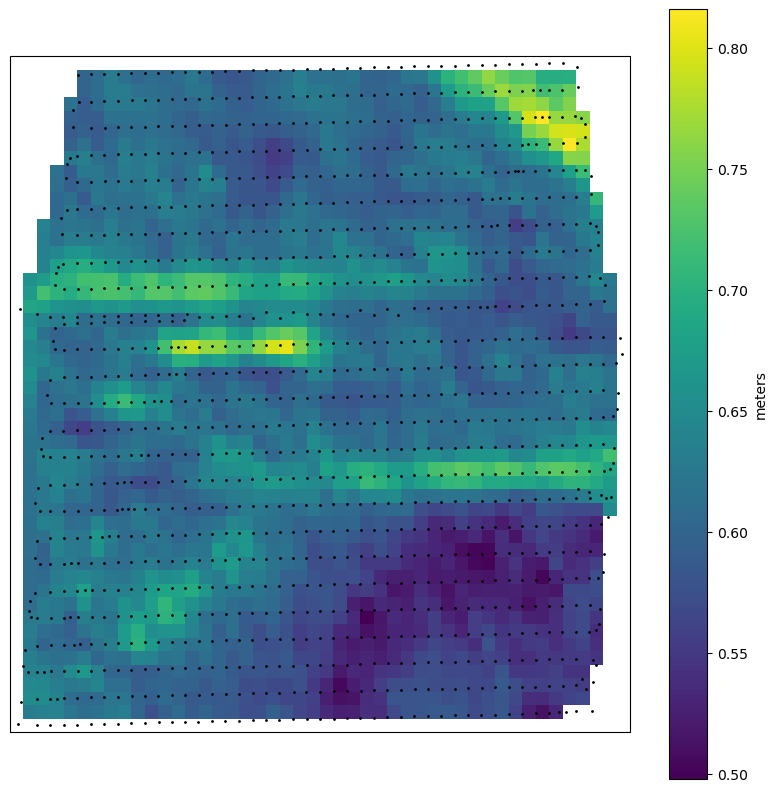

In [79]:
grd = vd.ScipyGridder(method="linear").fit(coordinates, thick)

region = vd.get_region((df.x, df.y))

grd_xords = vd.grid_coordinates(region, spacing=spacing)

grid = grd.grid(
    coordinates=grd_xords,
    dims=["x", "y"],
    data_names="thick",
)

grid = vd.distance_mask(
    coordinates, maxdist=20, grid=grid
)

print("Generated grid:")
print(grid)

plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.UTM(6))
ax.set_title("Gridded Ice Thickness")

# Plot the gridded thickness
pc = grid.thick.plot.pcolormesh(
    ax=ax, add_colorbar=False
)
plt.colorbar(pc).set_label("meters")

# Plot the locations of the reduced data
ax.plot(*coordinates, ".k", markersize=2)
plt.show()

## Save a geotiff

In [69]:
thick_interp = np.array(grid.thick).astype(np.float32)
thick_interp[thick_interp == 0] = np.nan
transform = Affine.translation(x.min() - spacing / 2, y.min() - spacing / 2) * Affine.scale(spacing, spacing)

ds = rio.open(
    './chena_thick.tif',
    'w',
    driver='GTiff',
    height=thick_interp.shape[0],
    width=thick_interp.shape[1],
    count=1,
    dtype=thick_interp.dtype,
    crs='EPSG:32606',
    transform=transform,
)

ds.write(thick_interp, 1)
ds.close()